# Import library

In [1]:
from big_slam import load_test_data,recurrence_plot,wave_slam_detector,lead_lag_detector,max_peak_detector
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = "serif"

## Load stationary manoeuvre data

In [2]:
df_original = pd.read_pickle('SAAII_Data/Stationary/180.pkl')

#Accelerometers used
z_col =['CL01_S_Z',
        'CH03_P_Z_Back',
        'CH04_P_Z_Front',
        'CH05_S_Z_Back',
        'CH06_S_Z_Front',
        'ES01_S_Z',
        'FW01_P_Z',
        'ST01_S_Z',
        'ST02_P_Z',
        'SG01_S_Z',
        'SG03_P_Z']

df = df_original[z_col]
df.head()

CL01_S_Z  CH03_P_Z_Back  CH04_P_Z_Front  CH05_S_Z_Back  CH06_S_Z_Front  \
0 -0.134763      -0.097119       -0.075000      -0.146652       -0.026049   
1 -0.065051      -0.086054       -0.082768      -0.136148       -0.041330   
2 -0.013233      -0.095643       -0.075148      -0.135249       -0.035461   
3 -0.082602      -0.117810       -0.056986      -0.138378       -0.043388   
4 -0.069196      -0.127215       -0.061795      -0.140789       -0.058783   

   ES01_S_Z  FW01_P_Z  ST01_S_Z  ST02_P_Z  SG01_S_Z  SG03_P_Z  
0  0.127401  0.107562  0.413256 -0.352386 -0.070103 -0.108342  
1  0.114953  0.183434  0.550847  0.061155 -0.116647 -0.126303  
2  0.138426  0.215605 -0.414612  0.029284 -0.133115 -0.128144  
3  0.083566  0.196930 -0.395859 -0.176362 -0.048635 -0.110872  
4  0.107539  0.106428 -0.614523 -0.406162 -0.011308 -0.159410

# Pre-processing
## Filter to desired frequency band

### Figure 5.1 - Frequency band examples

In [3]:
#Filter the signal 1-20 Hertz
lp_1 = signal.butter(10, 1, btype='lp', fs=2048, output='sos')

bp_1_5 = signal.butter(10, (1,6), btype='bandpass', fs=2048, output='sos')

bp_5_10 = signal.butter(10, (6,9), btype='bandpass', fs=2048, output='sos')

bp_10_15 = signal.butter(10, (9,15), btype='bandpass', fs=2048, output='sos')


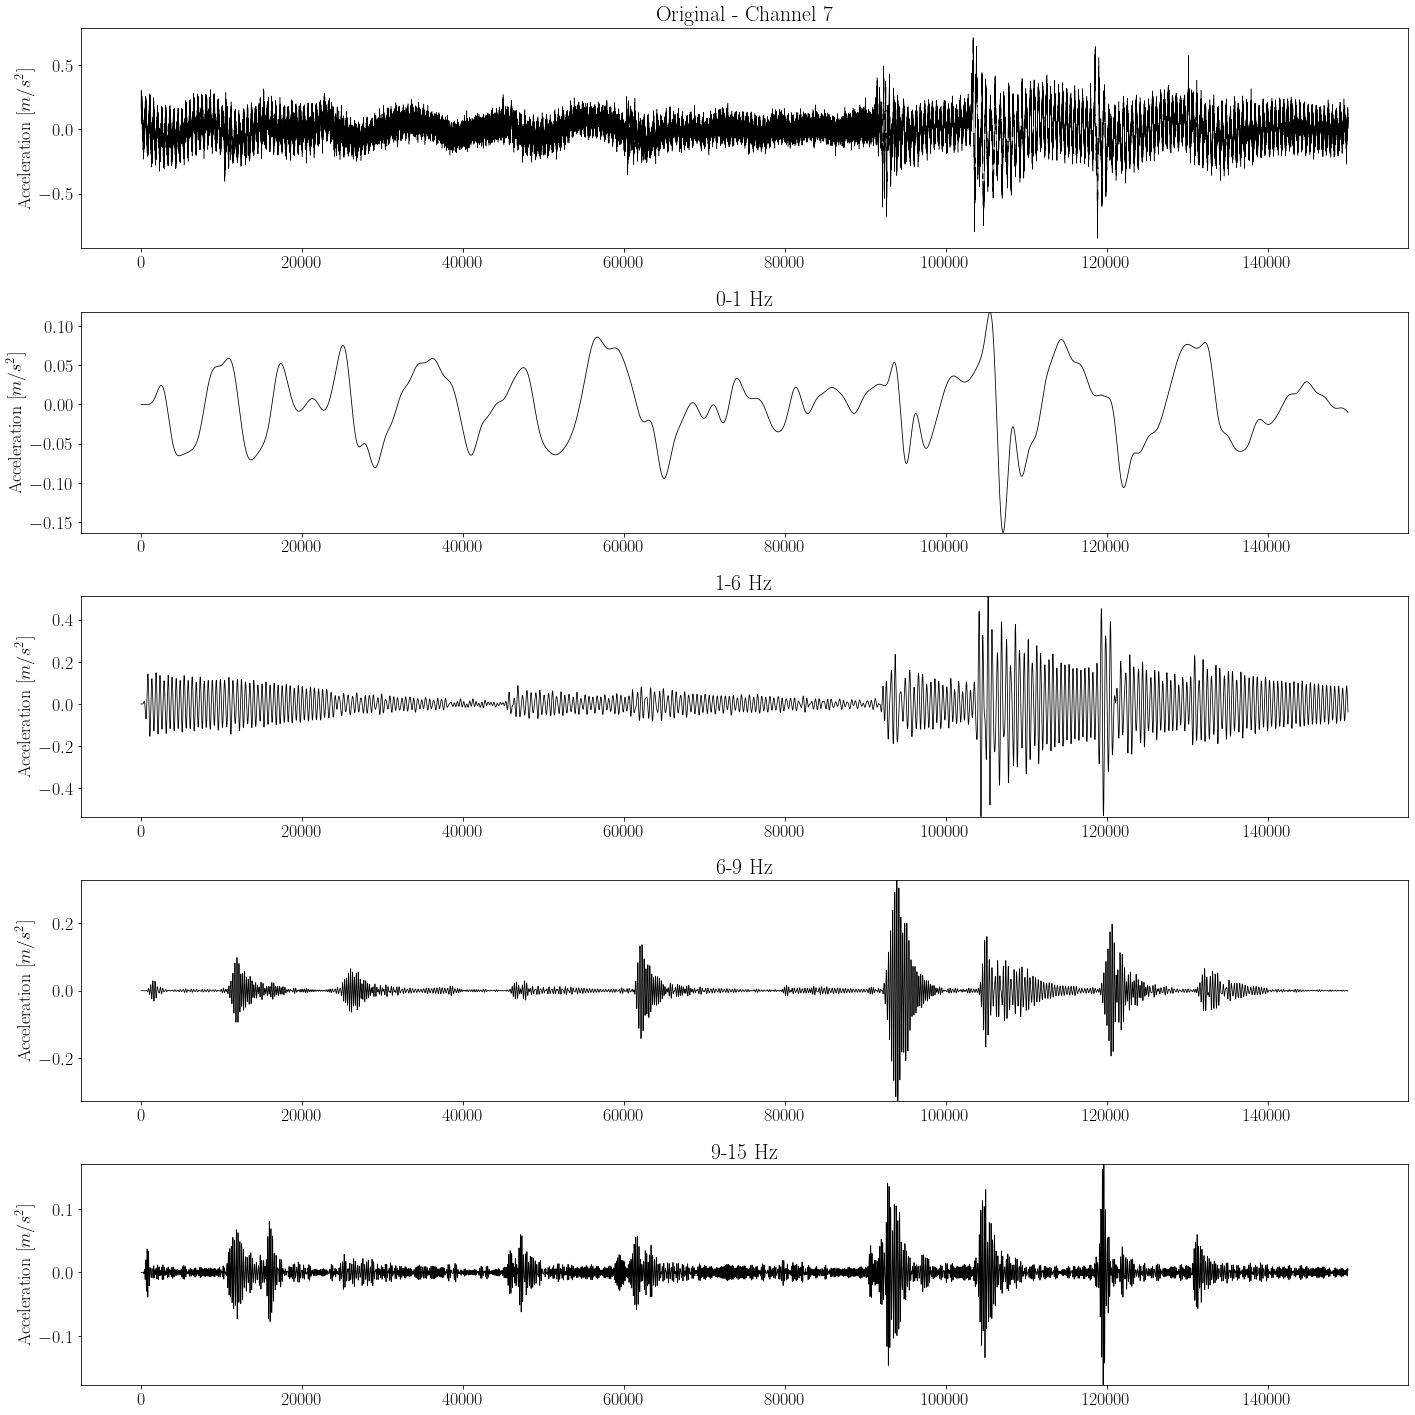

In [4]:
#Set plot parameters
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"

filters = [lp_1,bp_1_5,bp_5_10,bp_10_15]
filter_names = ['Original - Channel 7','0-1 Hz','1-6 Hz','6-9 Hz','9-15 Hz']

fig,ax = plt.subplots(5,1,figsize=(20,20))

x = df.iloc[155000:305000,5].values

ax[0].plot(x,'k',linewidth=0.5)
ax[0].set_title(filter_names[0])
ax[0].set_ylabel(r'Acceleration [$m/s^2$]')

for i,f in enumerate(filters):
    
    s = signal.sosfilt(f, x)
    ax[i+1].plot(s,'k',linewidth=0.8)
    ax[i+1].set_title(filter_names[i+1])
    ax[i+1].set_ylim(min(s),max(s))
    ax[i+1].set_ylabel(r'Acceleration [$m/s^2$]')
    
plt.tight_layout()
#plt.savefig('SAAII_frequency_bands.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

### Frequency bands viewed in a multivariate sense

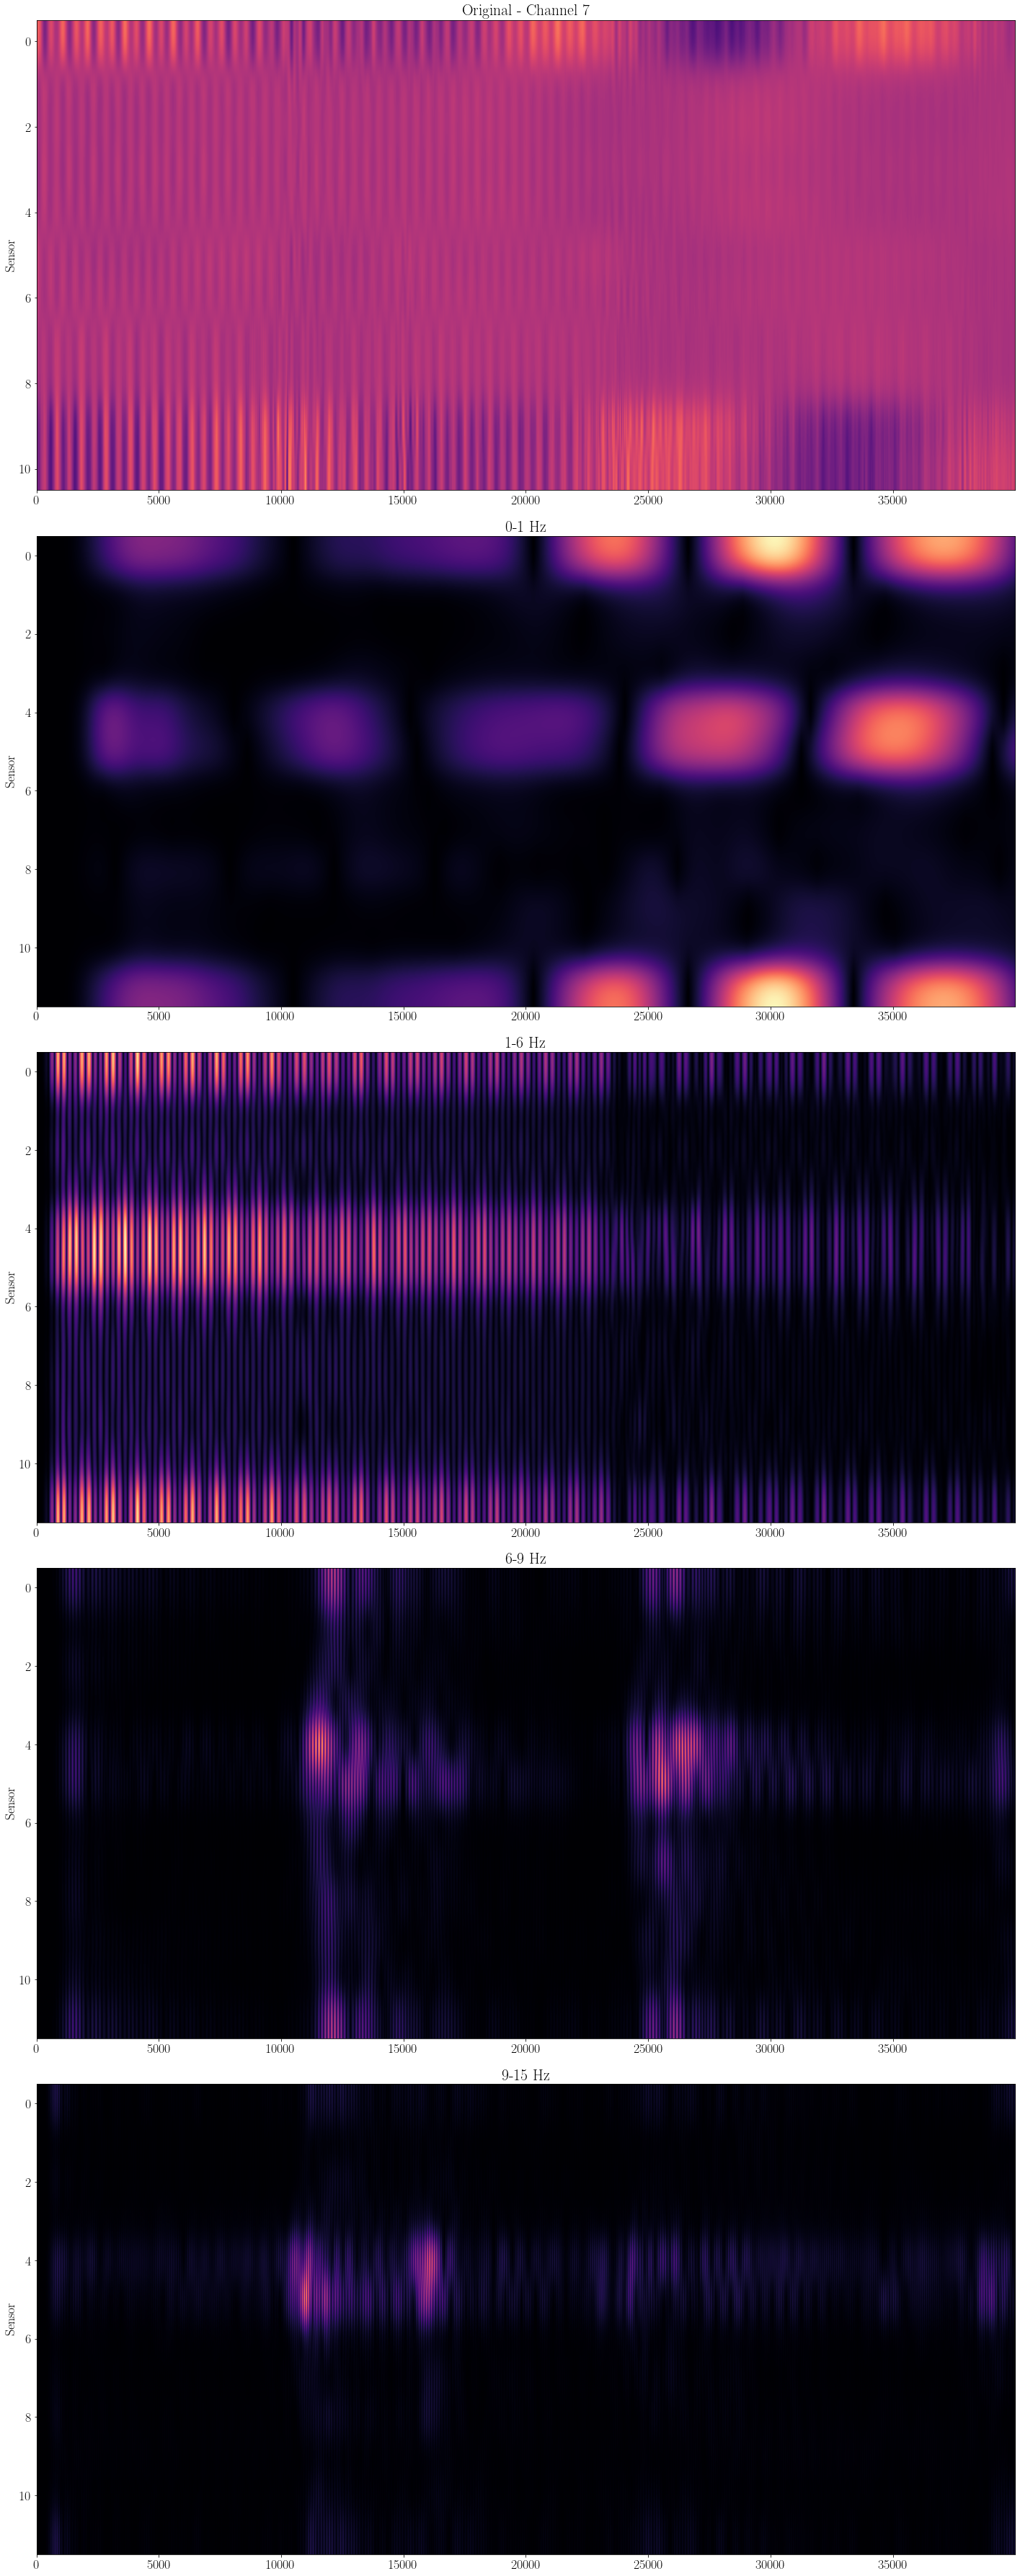

In [5]:
#Set plot parameters
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"

filters = [lp_1,bp_1_5,bp_5_10,bp_10_15]
filter_names = ['Original - Channel 7','0-1 Hz','1-6 Hz','6-9 Hz','9-15 Hz']

fig,ax = plt.subplots(5,1,figsize=(20,50))

x = df.iloc[155000:195000,:].values

ax[0].imshow(x.T,aspect='auto'
           ,interpolation = 'gaussian'
           ,cmap='magma')

ax[0].set_title(filter_names[0])
ax[0].set_ylabel('Sensor')

for i,f in enumerate(filters):

    df_img_filtered = df.iloc[155000:195000,:].copy()

    for col in df.columns[:]:
        df_img_filtered[col] = signal.sosfilt(f, df_img_filtered[col].values)
        
    img_d = df_img_filtered.iloc[:,[0,2,3,7,9,10,8,6,5,4,1,0]].abs()
    ax[i+1].imshow(img_d.T,aspect='auto'
           ,interpolation = 'gaussian'
           ,cmap='magma')
    
    ax[i+1].set_title(filter_names[i+1])
    #ax[i+1].set_ylim(min(s),max(s))
    ax[i+1].set_ylabel('Sensor')
    
plt.tight_layout()

It can be seen in the above images that the frequency band 6 to 9 Hertz clearly captures the traveling impact wave front as it travels through the vessel.

In [6]:
#Filter the signal 6-9 Hertz
sos = signal.butter(3, (6,9), btype='bandpass', fs=2048, output='sos')
df_filtered = df.copy()

for col in df.columns[:]:
    df_filtered[col] = signal.sosfilt(sos, df[col].values)

## Normalization

In [7]:
#Robust scale the data
scaler = RobustScaler()
df_Scaled = df_filtered.copy()
df_Scaled.iloc[:,:] = scaler.fit_transform(df_filtered)

In [8]:
df_Scaled.describe()

CL01_S_Z  CH03_P_Z_Back  CH04_P_Z_Front  CH05_S_Z_Back  \
count  1.843200e+06   1.843200e+06    1.843200e+06   1.843200e+06   
mean  -1.759043e-03  -1.512755e-03    6.897271e-05   2.727949e-03   
std    2.953172e+00   2.168480e+00    2.697018e+00   2.807547e+00   
min   -7.499296e+01  -4.801421e+01   -6.141605e+01  -6.806044e+01   
25%   -5.034246e-01  -5.024435e-01   -4.994313e-01  -4.963583e-01   
50%    0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
75%    4.965754e-01   4.975565e-01    5.005687e-01   5.036417e-01   
max    7.304034e+01   4.487634e+01    6.257264e+01   6.764402e+01   

       CH06_S_Z_Front      ES01_S_Z      FW01_P_Z      ST01_S_Z      ST02_P_Z  \
count    1.843200e+06  1.843200e+06  1.843200e+06  1.843200e+06  1.843200e+06   
mean     1.866598e-03 -4.606281e-04  2.003922e-03  3.638495e-04 -1.041566e-03   
std      3.129373e+00  3.102460e+00  3.159629e+00  3.674010e+00  3.743538e+00   
min     -5.678629e+01 -8.570466e+01 -9.273891e+01 -6.124826e+01 -8.121790e+01   
25%     -4.974020e-01 -5.016994e-01 -4.976768e-01 -5.011333e-01 -5.023834e-01   
50%      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%      5.025980e-01  4.983006e-01  5.023232e-01  4.988667e-01  4.976166e-01   
max      5.901059e+01  8.647818e+01  9.184416e+01  6.662562e+01  8.574548e+01   

           SG01_S_Z      SG03_P_Z  
count  1.843200e+06  1.843200e+06  
mean   1.098417e-03  2.899124e-04  
std    2.596426e+00  2.490251e+00  
min   -5.394308e+01 -5.802664e+01  
25%   -4.987338e-01 -4.993489e-01  
50%    0.000000e+00  0.000000e+00  
75%    5.012662e-01  5.006511e-01  
max    5.096487e+01  6.204232e+01

## Subsample

In [9]:
#Create sub_sampled index
sub_sampled_index = np.arange(0,df_filtered.shape[0],32)
df_filtered_subsampled = df_Scaled.iloc[sub_sampled_index,:]

df_unfiltered_subsampled = df.iloc[sub_sampled_index,:]

In [10]:
df_filtered_subsampled

CL01_S_Z  CH03_P_Z_Back  CH04_P_Z_Front  CH05_S_Z_Back  \
0       -0.001769      -0.001496        0.000084       0.002723   
32      -0.009804      -0.061631       -0.015458      -0.074682   
64      -0.052163      -0.314350       -0.067618      -0.403053   
96      -0.084171      -0.496331       -0.079880      -0.692836   
128     -0.052269      -0.168020        0.037009      -0.345244   
...           ...            ...             ...            ...   
1843040  0.232292      -0.370804       -0.072075      -0.618330   
1843072  0.453095      -0.649043       -0.362997      -0.113219   
1843104  0.487453      -0.656580       -0.523636       0.298487   
1843136  0.305037      -0.449709       -0.514508       0.440923   
1843168 -0.031118      -0.149839       -0.342096       0.365817   

         CH06_S_Z_Front  ES01_S_Z  FW01_P_Z  ST01_S_Z  ST02_P_Z  SG01_S_Z  \
0              0.001869 -0.000446  0.002002  0.000380 -0.001047  0.001094   
32            -0.021972  0.053448  0.065338 -0.090243 -0.110524 -0.006557   
64            -0.149784  0.274898  0.281195 -0.530163 -0.572279 -0.034762   
96            -0.268937  0.449137  0.341948 -0.910712 -0.935621 -0.032339   
128           -0.142098  0.196543 -0.028338 -0.465026 -0.435529  0.056986   
...                 ...       ...       ...       ...       ...       ...   
1843040       -0.424823 -0.463724  0.153180  0.021550  0.076889 -0.047228   
1843072       -0.677787 -0.695953  0.229091 -0.288407 -0.079564  0.153245   
1843104       -0.553359 -0.599757  0.153436 -0.521975 -0.171938  0.288908   
1843136       -0.080340 -0.325558  0.027014 -0.440045 -0.047579  0.242175   
1843168        0.463021 -0.071428 -0.033816 -0.050524  0.226653  0.043663   

         SG03_P_Z  
0        0.000268  
32      -0.007221  
64      -0.035305  
96      -0.046634  
128      0.021632  
...           ...  
1843040 -0.101790  
1843072  0.424358  
1843104  0.852021  
1843136  0.878982  
1843168  0.387214  

[57600 rows x 11 columns]

## Plot filtered subsampled data

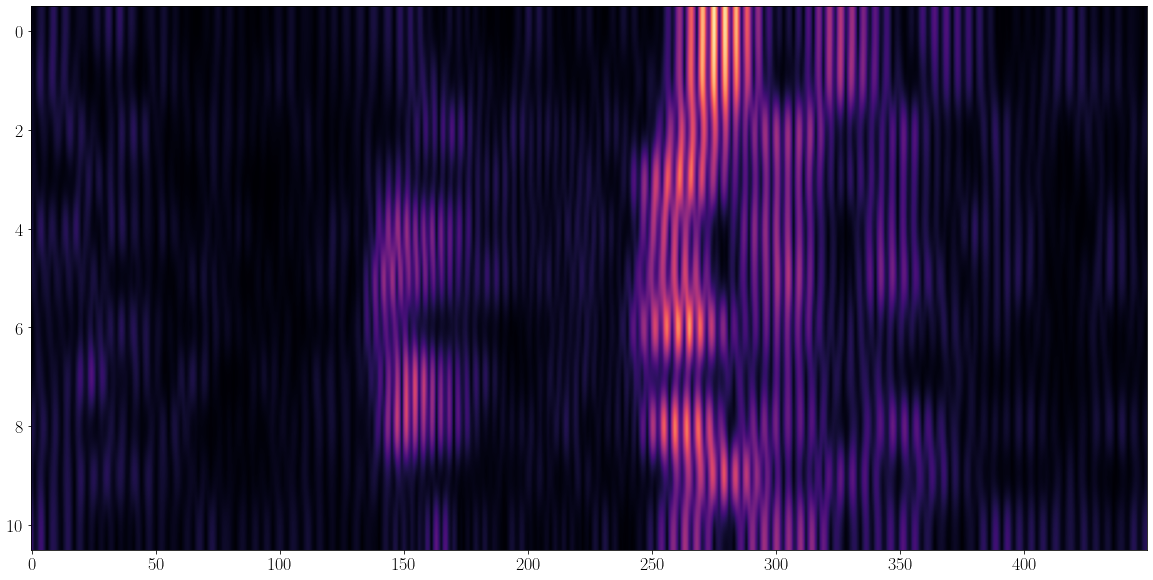

In [11]:
from skimage.transform import resize
fig,ax = plt.subplots(figsize=(20,10))
img_d = df_filtered_subsampled.iloc[13750:14200,[0,2,3,7,9,10,8,6,5,4,1]].abs()

#img_d = resize(img_d.abs().values,(50,50),anti_aliasing=True)

plt.imshow(img_d.T,aspect='auto'
           ,interpolation = 'gaussian'
           ,cmap='magma'
          )


# Feature extraction
### Using Recurrence plots and pretrained VGG16 CNN

In [13]:
%%time
#Parameters
window_size = 100
stride = 75
compressed_window_size = 100
recurrence_plot_type_1 = 'euclidean'
recurrence_plot_type_2 = 'none'

#create class
wave_slam_class_euc = wave_slam_detector(df_filtered_subsampled.iloc[:,[0,2,3,7,9,10,8,6,5,4,1]])
wave_slam_class_maha = wave_slam_detector(df_filtered_subsampled.iloc[:,[0,2,3,7,9,10,8,6,5,4,1]])

wave_slam_class_euc.feature_extraction(window_size,stride,compressed_window_size,recurrence_plot_type_1)
wave_slam_class_maha.feature_extraction(window_size,stride,compressed_window_size,recurrence_plot_type_2)


CPU times: user 7min 28s, sys: 8.5 s, total: 7min 37s
Wall time: 3min 9s


## Dimensionality reduction
### PCA : number of components = 30
### Figure 5.2

CPU times: user 1.23 s, sys: 105 ms, total: 1.34 s
Wall time: 524 ms


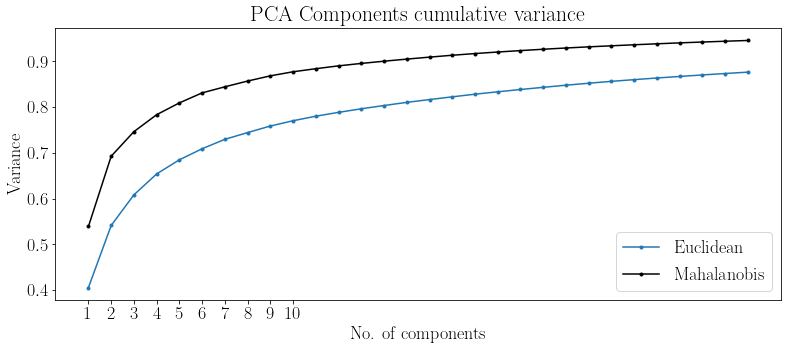

In [14]:
%%time

wave_slam_class_euc.PCA(max_components = 30)
wave_slam_class_maha.PCA(max_components = 30)

#PCA transformation per image type
pca_euc = wave_slam_class_euc.pca_model
pca_maha = wave_slam_class_maha.pca_model


fig,ax = plt.subplots(figsize=(13,5))
plt.plot(np.cumsum(pca_euc.explained_variance_ratio_),marker='.',label = 'Euclidean')
plt.plot(np.cumsum(pca_maha.explained_variance_ratio_),marker='.',label = 'Mahalanobis',c='k')
plt.xticks(range(10))
ax.set_xticklabels(np.arange(10)+1)
plt.title('PCA Components cumulative variance');
plt.xlabel('No. of components');
plt.ylabel('Variance');
plt.legend()

#plt.savefig('PCA_wave_slam_euc_maha.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## UMAP - Uniform manifold approximation and projection
## Figure 5.3

CPU times: user 4.2 s, sys: 71 ms, total: 4.27 s
Wall time: 3.89 s


Text(0.5, 1.0, 'UMAP - Mahalanobis')

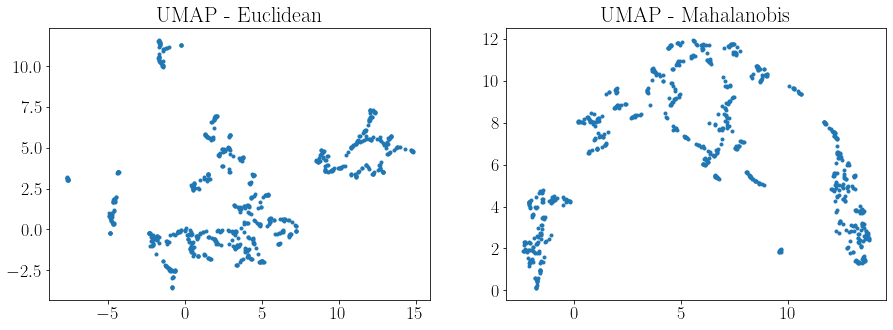

In [30]:
%%time
wave_slam_class_euc.UMAP(n_neighbors=4,min_dist=0,plot=False)
wave_slam_class_maha.UMAP(n_neighbors=6,min_dist=0,plot=False)


umap_trans_euc = wave_slam_class_euc.umap_transformed
umap_trans_maha = wave_slam_class_maha.umap_transformed


fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(umap_trans_euc[:,0],umap_trans_euc[:,1],marker='.')
ax[0].set_title('UMAP - Euclidean');
ax[1].scatter(umap_trans_maha[:,0],umap_trans_maha[:,1],marker='.')
ax[1].set_title('UMAP - Mahalanobis');

#plt.savefig('UMAP_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

# Clustering
## Figure 5.4

Text(0.5, 1.0, 'UMAP decomposition - Euclidean')

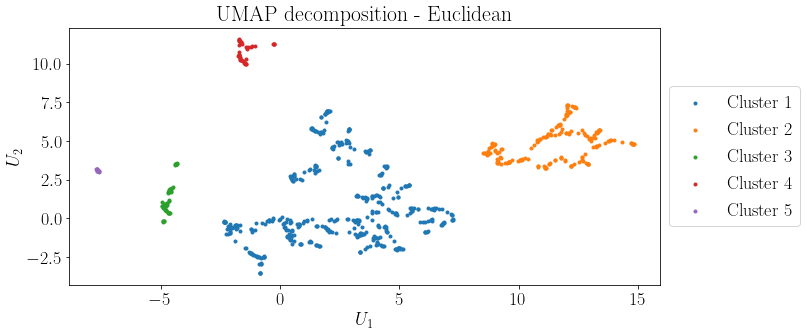

In [38]:

wave_slam_class_euc.clustering(eps=1.5,min_samples=5,plot=True)
plt.title('UMAP decomposition - Euclidean')

#plt.savefig('UMAP_cluster_labels_euclidean_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

Text(0.5, 1.0, 'UMAP decomposition - Mahalanobis')

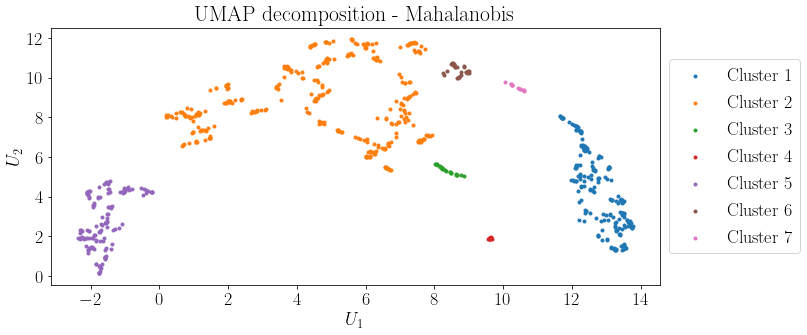

In [21]:
wave_slam_class_maha.clustering(eps=0.8,min_samples=5,plot=True)
plt.title('UMAP decomposition - Mahalanobis')
#plt.savefig('UMAP_cluster_labels_mahalanobis_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## Map cluster labels to time domain

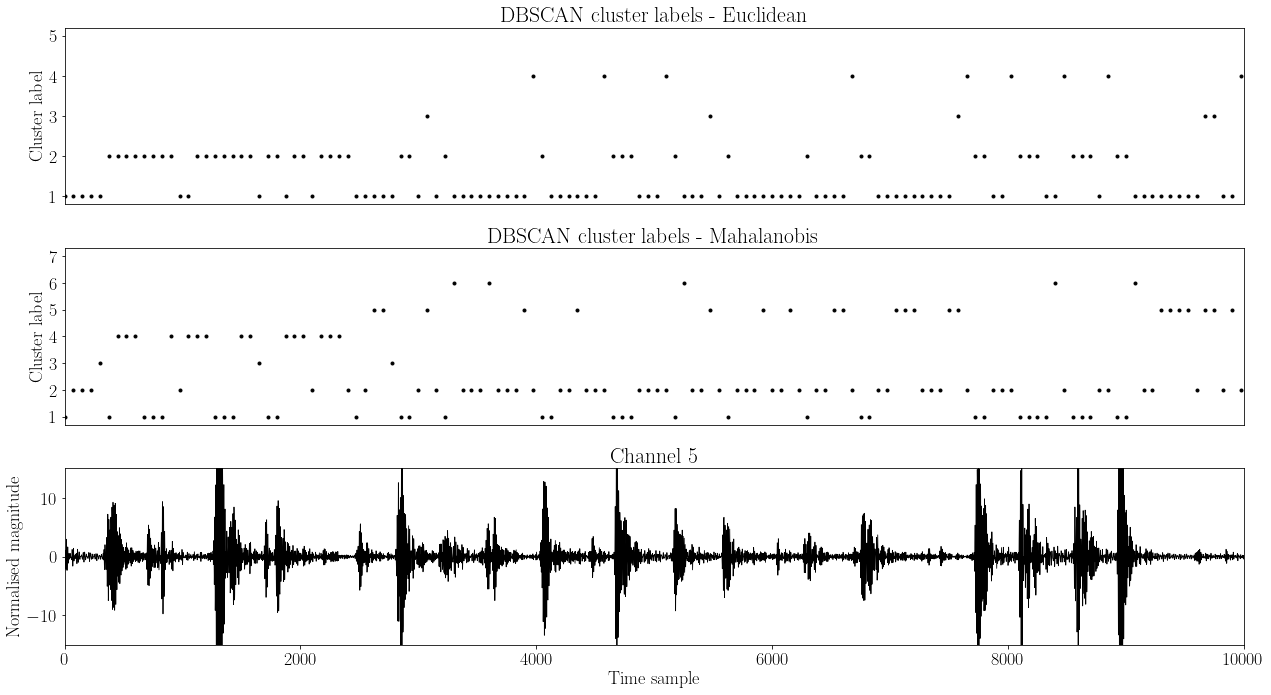

In [39]:
fig,ax = plt.subplots(3,1,figsize=(18,10))

ax[0].plot(wave_slam_class_euc.DBSCAN_feature_labels,'k.')
ax[0].set_ylabel('Cluster label')
ax[0].set_yticks(np.arange(1,wave_slam_class_euc.DBSCAN_feature_labels.max()+1))
ax[0].xaxis.set_visible(False)
ax[0].set_title('DBSCAN cluster labels - Euclidean');
ax[0].set_xlim(0,10000/stride)

ax[1].plot(wave_slam_class_maha.DBSCAN_feature_labels,'k.')
ax[1].set_ylabel('Cluster label')
ax[1].set_yticks(np.arange(1,wave_slam_class_maha.DBSCAN_feature_labels.max()+1))
ax[1].xaxis.set_visible(False)
ax[1].set_title('DBSCAN cluster labels - Mahalanobis');
ax[1].set_xlim(0,10000/stride)
#ax[1].set_ylim(1,stride)


ax[2].plot(df_filtered_subsampled.iloc[:,4].values,'k',linewidth=0.8)
ax[2].set_title('Channel 5');
ax[2].set_ylabel('Normalised magnitude')
ax[2].set_xlabel(r'Time sample');
ax[2].set_xlim(0,10000)
ax[2].set_ylim(-15,15)

plt.tight_layout()

#plt.savefig('Cluster_labels_in_time_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

# Classification
## Identify cluster corresponding to wave slamming

In [40]:
wave_slam_class_euc.chosen_cluster = 2
wave_slam_class_maha.chosen_cluster = 1

## Impact number and the approximate time of impact is given as:

In [41]:
# cluster in time using eps of 2 sample points
wave_slam_class_euc.clustering_in_time(eps=1);

wave_slam_class_maha.clustering_in_time(eps=1);

/Users/torick/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/torick/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Text(0, 0.5, 'Time sample')

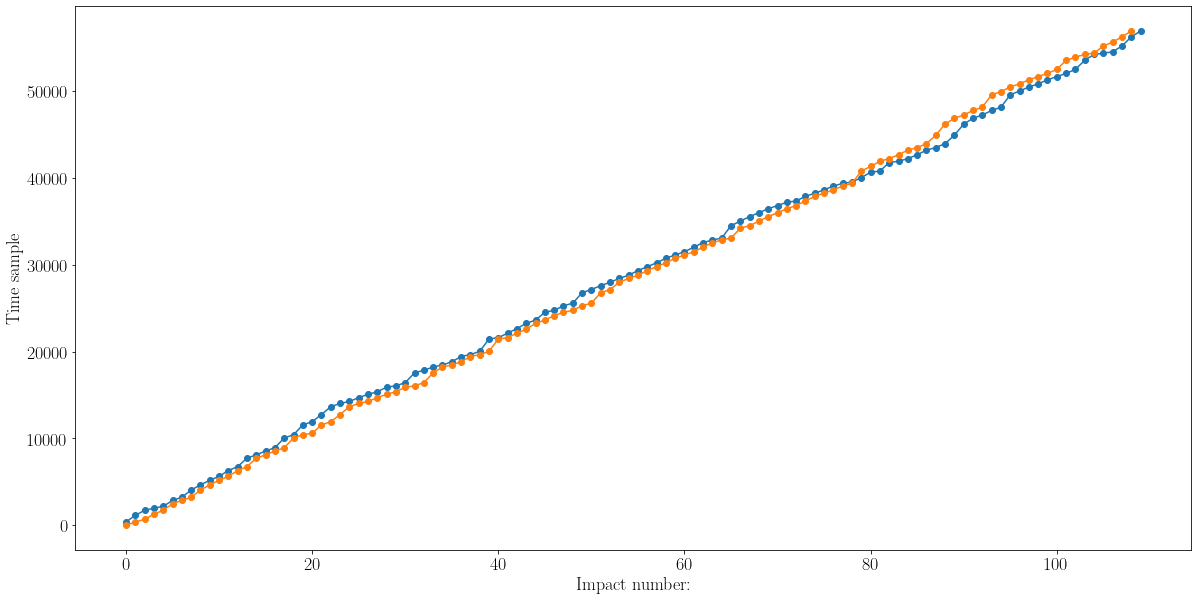

In [42]:
fig,ax = plt.subplots(figsize=(20,10))
#ax.vlines(wave_slam_class_euc.results_df['approximate_impact_time_sample'].values,0,1,color='r',linestyle='dashed',linewidth=5)
#ax.vlines(wave_slam_class_maha.results_df['approximate_impact_time_sample'].values,0,1,color='k',linewidth=5,alpha=0.5)
wave_slam_class_euc.results_df['approximate_impact_time_sample'].plot(ax=ax,marker='o')
wave_slam_class_maha.results_df['approximate_impact_time_sample'].plot(ax=ax,marker='o')

plt.xlabel('Impact number:')
plt.ylabel('Time sample')


## Evaluate results

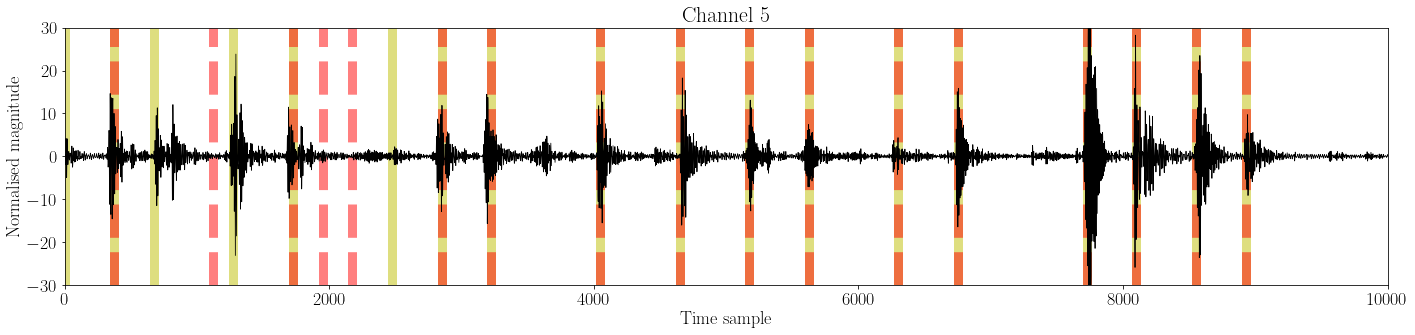

In [43]:
fig,ax = plt.subplots(figsize=(20,5))

ax.vlines(wave_slam_class_maha.results_df['approximate_impact_time_sample'].values,-30,30,linestyle='solid',linewidth=9,color='y',alpha=0.5)
ax.vlines(wave_slam_class_euc.results_df['approximate_impact_time_sample'].values,-30,30,linestyle='dashed',linewidth=9,color='r',alpha=0.5)
ax.plot(df_filtered_subsampled.iloc[:,5].values,'k',linewidth=0.8)
ax.set_title('Channel 5');
ax.set_ylabel('Normalised magnitude');
ax.set_xlabel(r'Time sample');
ax.set_xlim(0,10000)
ax.set_ylim(-30,30)

plt.tight_layout()


## Associated RPs

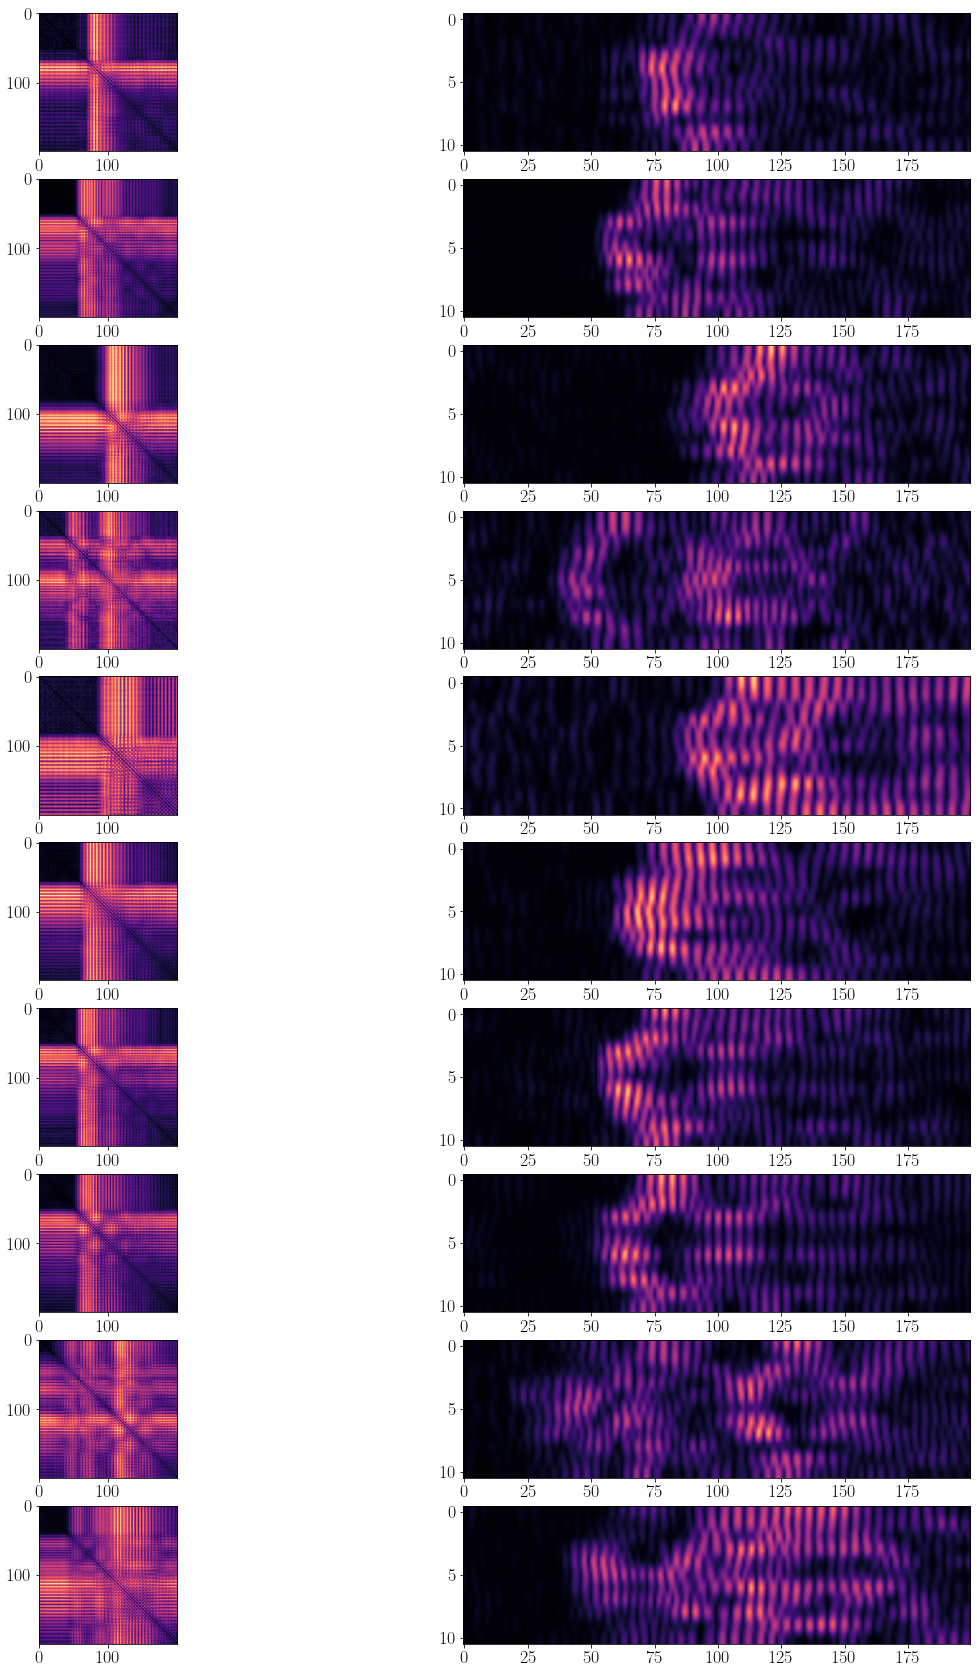

In [44]:
w_times = wave_slam_class_euc.results_df['approximate_impact_time_sample'].values
fig,ax = plt.subplots(len(w_times[60:70]),2,figsize=(20,30))

for i_index,i in enumerate(w_times[60:70]):
    img_data = df_filtered_subsampled.iloc[i-100:i+100,[0,2,3,7,9,10,8,6,5,4,1]].abs()
    img = recurrence_plot(img_data,'euclidean')
    ax[i_index,0].imshow(img,aspect='equal',cmap='magma')#,vmin=0,vmax=1)
    ax[i_index,1].imshow(img_data.T,aspect='auto',cmap='magma',vmin=0,interpolation='gaussian')
    #print(mode_values[60+i_index])

# Find impact locations

In [45]:
w_times = wave_slam_class_maha.results_df['approximate_impact_time_sample'].values[1:]

location_window_size  = 50
locations = []
de = [0,1,2,3,4,5,6,7,8,9,10,15]

for d in de:
    local =[]
    for i in w_times:
        img_data = df_filtered_subsampled.iloc[i-location_window_size:i+location_window_size,:]

        local.append(lead_lag_detector(img_data,11,d).pulse_location)
        
    locations.append(local)    

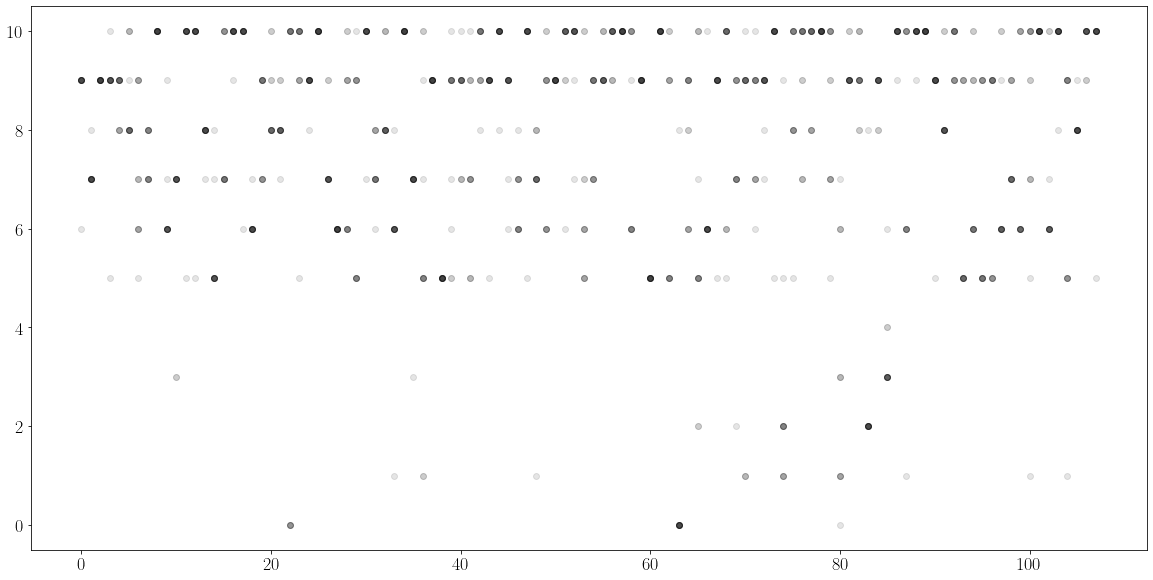

In [47]:
plt.figure(figsize=(20,10))
for l in range(len(locations)):
    plt.scatter(np.arange(len(locations[l])),locations[l],marker='o',alpha=0.1,color='k')

In [48]:
from scipy.stats import mode
location_A = np.array(locations)
mode_values =[]
for i in range(location_A.shape[1]):
    mode_values.append(mode(location_A[:,i])[0][0])
    
print(df_filtered_subsampled.columns[mode(mode_values)[0][0]])

SG03_P_Z


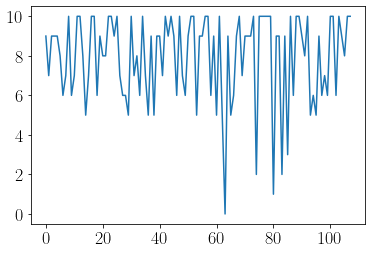

In [49]:
plt.plot(mode_values)

In [50]:
wave_slam_class_maha.results_df['Location'] = mode_values
wave_slam_class_maha.results_df


ValueError: Length of values (108) does not match length of index (109)

## Export results

In [ ]:
#wave_slam_class.results_df.to_csv('Region_2_results.csv')